In [1]:
# the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../codes')
import os
import cv2
import matplotlib.pyplot as plt
from video_handling import videoObj

/home/wesley.passos/miniconda3/envs/mosquitoes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
#make matplotlib figures appear inline in the notebook
#rather than in a new window.
%matplotlib inline
#sns.set()
# set default size of plots
plt.rcParams['figure.figsize'] = (12.0, 10.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


In [17]:
video_path = '../data/CEFET/VideoDataSet'
annot_path = '../data/CEFET/zframer-marcacoes/'

In [5]:
video_file = '5m/DJI00804_05m_04aTomada.mp4'
vid = videoObj(os.path.join(video_path,video_file))

In [6]:
f = vid.get_all_frames()

In [7]:
f.shape

(525, 1080, 1440, 3)

In [9]:
%timeit vid.get_all_frames()

3.24 s ± 62.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


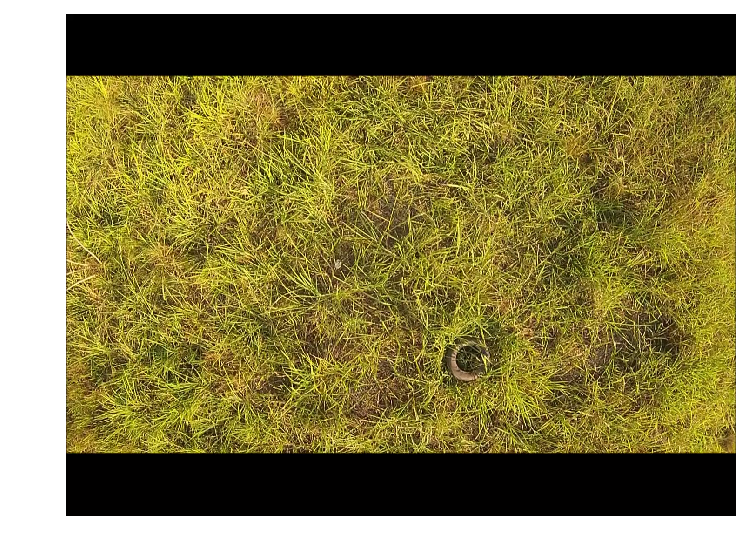

In [10]:
#displaying frame
plt.imshow(cv2.cvtColor(f[2,],cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
from dataset import VideoDataset

In [18]:
dataset = VideoDataset(video_path,annot_path)

In [33]:
len(dataset)

62